<a href="https://colab.research.google.com/github/vaishnaviu/Face_Recognition/blob/main/final_project_group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
root_path = "/content/drive/MyDrive/Colab Notebooks/data"
train_path = root_path + "/train"
grade_path = root_path + "/grade"

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Data, plotting, math
import matplotlib.pyplot as plt # generalized plotting
import math
import pandas as pd # for dataframes
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report # accuracy!
from sklearn.model_selection import cross_val_score # cross-val!
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Preprocessing
import cv2 #images!
import os # filesystem
from keras.preprocessing import image # built in image preprocessing. This is a deep learning library but it's very helpful for image work.
from keras.preprocessing.image import ImageDataGenerator # generate new test cases
from sklearn.model_selection import train_test_split # easy train-test split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow_datasets as tfds

import shutil

# Classifiers
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

#SVM
from sklearn import svm

In [ ]:
# Function to read mapping file and create a dictionary of filename-label pairs
def read_mapping_file(file_path):
    mapping_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            filename, label = line.strip().split()
            mapping_dict[filename] = label
    return mapping_dict

# Function to preprocess images
def preprocess_images(image_folder, label_mapping):
    image_data = []
    labels = []

    # Verify label mapping
    print("Sample Mapping:")
    for filename, label in list(label_mapping.items())[:5]:  # Print the first 5 samples
        print(f"{filename}: {label}")

    # Iterate through images in the folder
    for filename in os.listdir(image_folder):
        # Skip hidden files
        if filename.startswith('.'):
            continue

        # Get the label from the mapping dictionary
        label = label_mapping.get(filename, None)
        if label == 'wufangyuan':
            print(filename)
            continue

        labels.append(label)
        # Read and preprocess the image
        image_path = os.path.join(image_folder, filename)
        img = cv2.imread(image_path)
        img = cv2.resize(img, (200, 200))  # Resize for consistency
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = image.img_to_array(img)  # Convert to array

        # Append the preprocessed image to the list
        image_data.append(img)

    # Convert lists to NumPy arrays
    image_data = np.array(image_data)
    labels = np.array(labels)

    return image_data, labels

# Driver to detect and crop a head in an image, given a limiting factor based on how close we want to crop the face.
# The cropping is achieved by specifying a factor that determines the size of the cropped region around the detected face.
# SOURCE: https://gist.github.com/Norod/223b81b7131cec3ac21cf3be3e47a597

def detect_and_crop_head(face_cascade, input_image_path, output_image_path, factor=0.9):

    # Read the input image using PIL
    image = Image.open(input_image_path)

    # Convert PIL image to OpenCV format (BGR)
    cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Convert the image to grayscale for face detection
    gray_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.3, minNeighbors=2)

    if len(faces) > 0:
        # Assuming the first face is the target, you can modify this based on your requirements
        x, y, w, h = faces[0]

        # Calculate the new coordinates and dimensions for a 1:1 aspect ratio
        center_x = x + w // 2
        center_y = y + h // 2
        size = int(max(w, h) * factor)
        x_new = max(0, center_x - size // 2)
        y_new = max(0, center_y - size // 2)

        # Crop the head region with a 1:1 aspect ratio
        cropped_head = cv_image[y_new:y_new+size, x_new:x_new+size]

        # Convert the cropped head back to PIL format
        cropped_head_pil = Image.fromarray(cv2.cvtColor(cropped_head, cv2.COLOR_BGR2RGB))

        # Save the cropped head image
        cropped_head_pil.save(output_image_path)
        print("Cropped head saved successfully.")
    else:
        print("No faces detected in the input image - manually cropped to default minimum crop and saved to output.")


# Function to augment images with horizontal flip, brightness adjustments
def augment_images(images, labels, output_folder, dataset_type, mapping):
    # Create the output folder if it doesn't exist

    shutil.rmtree(output_folder, ignore_errors=True)
    os.makedirs(output_folder, exist_ok=True)

    # Augmentation parameters
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        brightness_range=[0.5, 1.5],  # Adjust brightness levels
        fill_mode='nearest'
    )

    # Dictionary to store mapping between augmented filenames and labels
    augmented_mapping = {}
    num_images = 10

    # Iterate through images and labels
    for i, (img, label) in enumerate(zip(images, labels)):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb = img_rgb.reshape((1,) + img_rgb.shape)  # Reshape for flow method

        # Generate a fixed number of augmented images for each original image
        for augmented_counter in range(num_images):  # Adjust the number of augmented images per original
            augmented_img = next(datagen.flow(img_rgb, batch_size=1))[0]

            augmented_filename = f"{dataset_type}_image_{i}_label_{label}_augmented_{augmented_counter}.jpg"
            augmented_path = os.path.join(output_folder, augmented_filename)
            cv2.imwrite(augmented_path, augmented_img)

            # Store mapping in the dictionary
            augmented_mapping[augmented_filename] = label

        print(f"Processed {num_images} augmented images for original image {i} - Label: {label}")

    # Check if labels are missing in augmented_mapping
    missing_labels = set(labels) - set(augmented_mapping.values())
    if missing_labels:
        print(f"Warning: Labels are missing for the following images: {missing_labels}")

    # Return the mapping dictionary
    return augmented_mapping

# Function to display sample images
def display_sample_images(folder):
    images = []

    # Load and filter valid images
    for filename in os.listdir(folder)[45:55]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if the image is successfully loaded
        if img is not None:
            images.append(img)

    # Display the sample images
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Normalize values for display
        plt.axis('off')

    plt.show()

# Function to load, resize, and flatten images from a folder
def load_resize_and_flatten_images(folder, target_size=(100, 100)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        resized_img = cv2.resize(img, target_size)  # Resize the image to a common size
        images.append(resized_img.flatten())  # Flatten the resized image to a 1D array

    return np.array(images)

Sample Mapping:
0123_1.jpeg: wukaiyue
0123_2.jpeg: vanderlindenilona
0123_3.jpeg: zhangyuanzhen
0123_4.jpeg: liuhongji
0123_5.jpeg: lozanoroberto
(392, 200, 200, 3)


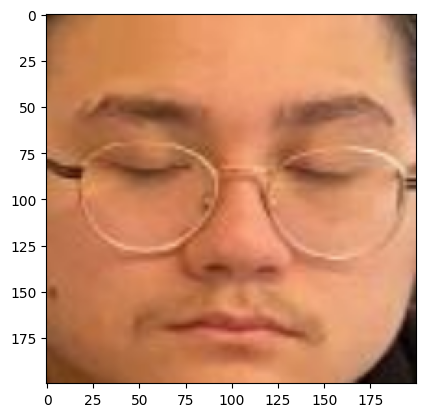

Sample Mapping:
0220_1.jpeg: liuhongji
0220_2.jpeg: wukaiyue
0220_3.jpeg: amarisian
0220_4.jpeg: chientingwei
0220_5.jpeg: yashasvi
(31, 200, 200, 3)


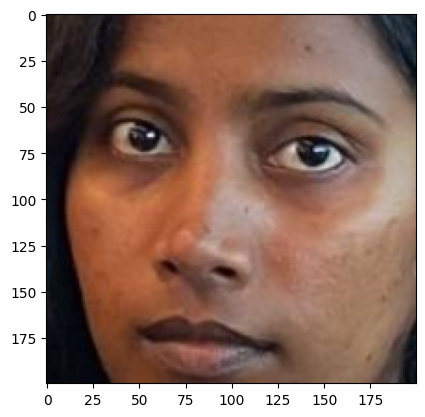

In [ ]:
# train_path = training path
# grade_path = testing path

mapping_file = root_path + "/file_mapping_train.txt"

# Collects all labels into a dictionary, label_mappings.
label_mappings = read_mapping_file(mapping_file)

# Preprocess initial training data
original_dataset_x, original_tags_y = preprocess_images(train_path, label_mappings)

print(original_dataset_x.shape)
plt.imshow(original_dataset_x[0] / 255.0)  # Display the first image (normalized)
plt.show()

mapping_file_test = root_path + "/file_mapping_test.txt"

# Collects all labels into a dictionary, label_mappings_test
label_mappings_test = read_mapping_file(mapping_file_test)

# Preprocess initial testing data
original_dataset_x_test, original_tags_y_test = preprocess_images(grade_path, label_mappings_test)

print(original_dataset_x_test.shape)
plt.imshow(original_dataset_x_test[0] / 255.0)  # Display the first image (normalized)
plt.show()

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

test_filenames = []
# Output folder for augmented  TRAIN images
output_folder_augmented = root_path + "/train_data_augmented"

# Augment faces for the initial dataset, get dictionary
augmented_mapping_original = augment_images(original_dataset_x, original_tags_y, output_folder_augmented, 'augmented_train', root_path + "file_mapping_aug.txt")

# Crop augmented train
for image_filename in augmented_mapping_original.keys():
  if image_filename == "filename":
    continue
  detect_and_crop_head(face_cascade, output_folder_augmented + (f"/{image_filename}"), output_folder_augmented + (f"/{image_filename}"))

# Crop ORIGINAL train
for image_filename in label_mappings.keys():
  if image_filename == "filename":
    continue
  detect_and_crop_head(face_cascade, train_path + (f"/{image_filename}"), train_path + (f"/{image_filename}"))

# Output folder for augmented TEST images
output_folder_augmented_test = root_path + "/test_data_augmented"

# Augment faces for the initial dataset, get dictionary
augmented_mapping_test = augment_images(original_dataset_x_test, original_tags_y_test, output_folder_augmented_test, 'augmented_test', root_path + "/test_file_mapping_aug.txt")

# Crop augmented test
for image_filename in augmented_mapping_test.keys():
  if image_filename == "filename":
    continue
  test_filenames.append(image_filename)
  detect_and_crop_head(face_cascade, output_folder_augmented_test + (f"/{image_filename}"), output_folder_augmented_test + (f"/{image_filename}"))

# Crop ORIGINAL test
for image_filename in label_mappings_test.keys():
  if image_filename == "filename":
    continue
  test_filenames.append(image_filename)
  detect_and_crop_head(face_cascade, grade_path + (f"/{image_filename}"), grade_path + (f"/{image_filename}"))

Streaming output truncated to the last 5000 lines.
Processed 10 augmented images for original image 76 - Label: somaniachal
Processed 10 augmented images for original image 77 - Label: liuhongji
Processed 10 augmented images for original image 78 - Label: zhangyuanzhen
Processed 10 augmented images for original image 79 - Label: zhouchuandi
Processed 10 augmented images for original image 80 - Label: ravijayanthidhanasekar
Processed 10 augmented images for original image 81 - Label: vanderlindenilona
Processed 10 augmented images for original image 82 - Label: vennavellirajashekarreddy
Processed 10 augmented images for original image 83 - Label: pereiranerissagodfrey
Processed 10 augmented images for original image 84 - Label: zotaharsh
Processed 10 augmented images for original image 85 - Label: banmingkai
Processed 10 augmented images for original image 86 - Label: selinayu
Processed 10 augmented images for original image 87 - Label: chenziang
Processed 10 augmented images for origin

In [ ]:
#load in original TRAIN dataset
original_dataset_resized = load_resize_and_flatten_images(train_path)

original_dataset_resized = np.array(original_dataset_resized)

print("Original dataset dimensions:")
print(original_dataset_resized.shape)

#load in original TEST dataset
test_set_resized = load_resize_and_flatten_images(grade_path)

test_set_resized = np.array(test_set_resized)

print("Original dataset dimensions:")
print(test_set_resized.shape)

#Load in augmented TRAIN dataset
augmented_dataset_x = load_resize_and_flatten_images(output_folder_augmented)

augmented_dataset_x = np.array(augmented_dataset_x)

augmented_tags_y = np.array(list(augmented_mapping_original.values()))

#Load in augmented TEST dataset
augmented_dataset_x_test = load_resize_and_flatten_images(output_folder_augmented_test)

augmented_dataset_x_test = np.array(augmented_dataset_x_test)

augmented_tags_y_test = np.array(list(augmented_mapping_test.values()))

Original dataset dimensions:
(392, 30000)
Original dataset dimensions:
(31, 30000)


In [ ]:
# Create combined dataset

combined_dataset_x = np.concatenate((augmented_dataset_x, original_dataset_resized))
combined_tags_y = np.concatenate((augmented_tags_y, original_tags_y))

combined_dataset_x_test = np.concatenate((augmented_dataset_x_test, test_set_resized))
combined_tags_y_test = np.concatenate((augmented_tags_y_test, original_tags_y_test))

print("Final Train dataset dimensions:")
print(combined_dataset_x.shape)
print(combined_tags_y.shape)

print("Final Test dataset dimensions:")
print(combined_dataset_x_test.shape)
print(combined_tags_y_test.shape)

Final Train dataset dimensions:
(4312, 30000)
(4312,)
Final Test dataset dimensions:
(341, 30000)
(341,)


Explained Variance Ratio (95% of variance) - Initial: 0.950206809718001


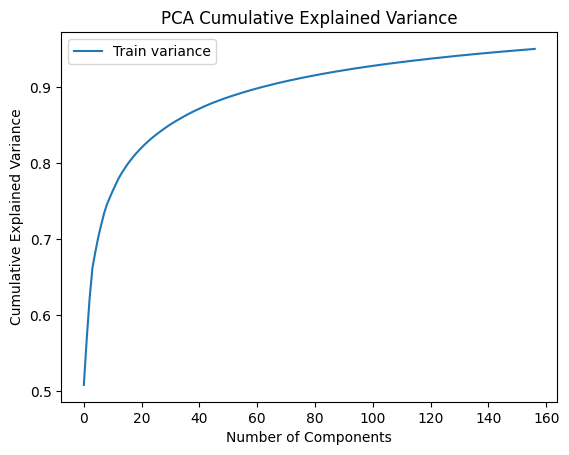

Shape after PCA - Initial: (4312, 157)


In [ ]:
# Perform PCA for each dataset
# num_components = Explains 95% of variance

pca = PCA(n_components=0.95, svd_solver = 'full')
pca_combined_dataset_x = pca.fit_transform(combined_dataset_x)

# # Run PCA on test data
pca_combined_dataset_x_test = pca.transform(combined_dataset_x_test)

# Print the explained variance ratio for each dataset
explained_variance_ratio = pca.explained_variance_ratio_

print(f"Explained Variance Ratio (95% of variance) - Initial: {explained_variance_ratio.sum()}")

# Plot the cumulative explained variance for each dataset
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_explained_variance, label='Train variance')  # Updated for validation set
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.legend()
plt.show()

print("Shape after PCA - Initial:", pca_combined_dataset_x.shape)

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_combined_dataset_x = lda.fit_transform(pca_combined_dataset_x, combined_tags_y)

lda_combined_dataset_x_test = lda.transform(pca_combined_dataset_x_test)
print(lda_combined_dataset_x.shape)

(4312, 31)


In [ ]:
# Initialize the SVM classifier
svm_classifier = SVC()

# Train the model on the initial training dataset
svm_classifier.fit(lda_combined_dataset_x, combined_tags_y)

# Predict labels for the test set
y_pred = svm_classifier.predict(lda_combined_dataset_x_test)

In [ ]:
preds_w_filenames = np.array([test_filenames, list(y_pred)]).transpose()
prediction = pd.DataFrame(preds_w_filenames, columns=["filename", "prediction"]).to_csv(root_path + '/prediction.csv')

In [ ]:
# Assuming the CSV file has columns 'sample_id' and 'ground_truth'
def calculate_accuracy(ground_truths, predictions):
    if len(ground_truths) != len(predictions):
        raise ValueError("The number of predictions does not match the number of ground truths.")
    correct_predictions = 0
    for sample_id, ground_truth in ground_truths.items():
        if predictions.get(sample_id) == ground_truth:
            correct_predictions += 1
    return correct_predictions / len(ground_truths)

def grade_predictions(predictions, grade_path=grade_path):
    df = pd.read_csv(grade_path + "/solution.csv")
    ground_truths = dict(zip(df['filename'], df['ground_truth']))
    accuracy = calculate_accuracy(ground_truths, predictions)
    return accuracy